# Predicting Customer Satisfaction using Decision Trees
This notebook uses the scraped data to build a decision tree regression model that tries to predict customer satisfaction.


## Step 1. Import the required libraries

In [53]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define constants
PRODUCT_DATA = 'data/decathlon_products.csv'
CHARACTERISTICS_DATA = 'data/decathlon_characteristics.csv'


## Step 2: Data preparation
### 2.1. Prepare product data.

In [54]:
def get_discount_magintude(row):
    if row['discount']:
        return round(abs(row['price'] - row['previous_price']),1)
    else:
        return 0
    

def encode_categorical_data(data, columns):
    for column in columns:
        data[column+'_encoded'] = LabelEncoder().fit_transform(data[column])
        data = data.drop(column, axis=1)
    return data


def set_index(data, index='product_id'):
    if index not in data.columns and 'id' in data.columns:
        data[index] = data['id']
    return data.set_index(index).astype('str')


def preprocess_product_data(filepath: str = PRODUCT_DATA):
    product_data = pd.read_csv(filepath)
    product_data = encode_categorical_data(product_data, ['brand', 'genre'])
    product_data['rating'] = product_data['rating'].fillna(0)
    product_data['discount_magnitude'] = product_data.apply(
        get_discount_magintude, axis=1)
    product_data = set_index(product_data)
    product_data = product_data.drop(
        ['name', 'sticker', 'discount', 'color', 'description', 'previous_price', '_id', 'id', 'n_reviews'],  axis=1)
    return product_data

product_data = preprocess_product_data()
print(product_data.head())

            price rating brand_encoded genre_encoded discount_magnitude
product_id                                                             
8821974     21.99    4.5            48             2               10.0
8869111     23.99    4.6             0             2                6.0
8869113     31.99    3.8             0             2                8.0
8789910      9.99    4.3            33             2                0.0
8547126      6.99    4.7            58             2                0.0


## Step 2. Data preparation.
### 2.2. Prepare characteristics data

In [55]:

def pivot_data(data, index, columns):
    data = data[[index, columns]]
    data = data.groupby(index).value_counts().reset_index()
    return data.pivot(index=index, columns=columns, values='count').fillna(0)


def preprocess_characteristics_data(filepath: str = CHARACTERISTICS_DATA):
    characteristics_data = pd.read_csv(filepath)
    characteristics_data['product_id'] = characteristics_data['product_id'].astype(
        'str')
    characteristics_data = pivot_data(
        characteristics_data, 'product_id', 'title')
    return characteristics_data


characteristics_data = preprocess_characteristics_data()
print(characteristics_data.head())

title       Adaptabilidad  Adherencia  Agarre ergonómico  Air retention  \
product_id                                                                
8150442               0.0         0.0                0.0            0.0   
8324591               0.0         0.0                0.0            0.0   
8368090               0.0         1.0                0.0            0.0   
8394289               0.0         1.0                0.0            0.0   
8406308               0.0         0.0                1.0            0.0   

title       Amortiguación  Ayuda al desarrollo psicomotor  Calidad de rebote  \
product_id                                                                     
8150442               0.0                             0.0                0.0   
8324591               0.0                             0.0                1.0   
8368090               0.0                             0.0                0.0   
8394289               0.0                             0.0                0

## Step 3. Data exploration
### Identification of similarities in the characteristics

In [56]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from itertools import product


CLUSTERS_CMAP = {
    0: 'r',
    1: 'g',
    2: 'b',
    3: 'y',
    4: 'c',
    5: 'm',
    6: 'k',
    7: 'brown',
    8: 'orange',
    9: 'pink',
    10: 'purple',
    11: 'olive',
    - 1: 'gray'
}

## Helper functions
def build_linkage_matrix(model):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix


def plot_dendrogram(ax, model, **kwargs):
    # Plot the corresponding dendrogram
    dendrogram(build_linkage_matrix(model), ax=ax, **kwargs)

    return ax

def inspect_data(data):
    clustering = AgglomerativeClustering(
            linkage='ward', compute_distances=True, compute_full_tree=True)  
    clustering.fit(StandardScaler().fit_transform(data))
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    plot_dendrogram(ax, clustering, labels=clustering.labels_)
    plt.show()
    return fig, ax
def cluster_data(data, n_clusters=3):
    clustering = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    return clustering.fit(StandardScaler().fit_transform(data))

def plot_clustering_results(data, clustering_model):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(data)
    ax = pca_plot(ax, data, transformed, pca.components_, cluster_labels = clustering_model.labels_, arrows=True)
    plt.show()
    return fig, ax


def pca_plot(ax, df, transformed, components, cluster_labels=None, columns=None, arrows=True):
    
    def add_arrow(ax, x, y, dx, dy, label, color='r', alpha=0.5, text_color='g', text_adjust=1.05):

        ax.arrow(x, y, dx, dy, color=color, alpha=alpha,
             head_width=0.02, head_length=0.02)

        ax.text(dx*text_adjust, dy*text_adjust, label,
            color=text_color, ha='center', va='center', fontsize=12)
        return ax

    if columns is None:
        columns = df.columns
    if cluster_labels is not None:
        for i in range(len(transformed)):
            ax.scatter(transformed[i, 0], transformed[i, 1],
                       color= CLUSTERS_CMAP[cluster_labels[i]], label=f'Cluster {cluster_labels[i]}')
        
    else:
        ax.scatter(transformed[:, 0], transformed[:, 1])

    if arrows:
        for i in range(len(components[0])):
            if np.sqrt(components[0, i]**2 + components[1, i]**2) > 0.3:
                ax = add_arrow(ax,  0, 0, components[0, i], components[1, i],
                               columns[i], color='black', text_color='black', text_adjust=1.1)
    ax.set_xticklabels(np.round(ax.get_xticks(), 2), fontsize=12)
    ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=12)
    return ax



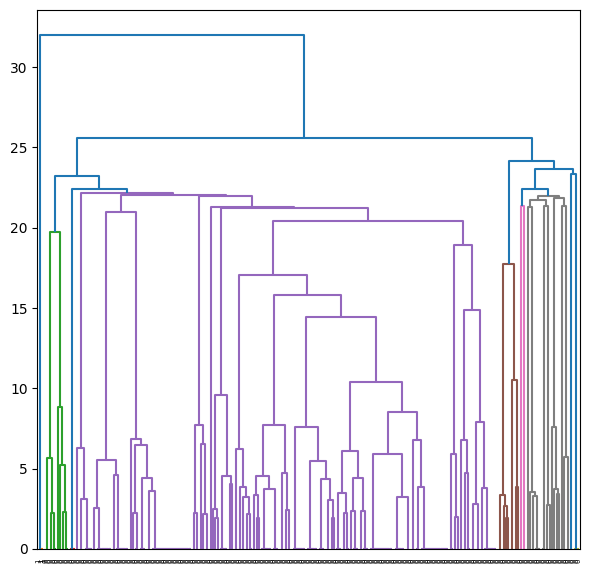

(<Figure size 700x700 with 1 Axes>, <Axes: >)

In [57]:
## Data inspection
inspect_data(characteristics_data)

Looking at the dendrogram we can see that the instances can be grouped in 2-4 groups with some outliers(Left side).
Lets find the optimal parameters  for the dbscan to obtain that exact number of clusters

silhouette_score=0.2132096995861017, n_clusters=2 inertia=7104.66854348995
silhouette_score=0.16351001415514066, n_clusters=3 inertia=6915.424709394227
silhouette_score=0.15921816112756115, n_clusters=4 inertia=6450.1279605586715
silhouette_score=0.16807334982165165, n_clusters=5 inertia=6164.199539903149
silhouette_score=0.12209812818251241, n_clusters=6 inertia=5929.939288814506
silhouette_score=0.09897629267827154, n_clusters=7 inertia=5677.334187702861
silhouette_score=0.15155839379665842, n_clusters=8 inertia=5388.753819159234
silhouette_score=0.1441709030936065, n_clusters=9 inertia=5196.866450727935
silhouette_score=0.13263901733785274, n_clusters=10 inertia=4920.819108278984
silhouette_score=0.04764853410584872, n_clusters=11 inertia=4670.558243158647
silhouette_score=0.1549043001549408, n_clusters=12 inertia=4408.526849064605
silhouette_score=0.1700424353330703, n_clusters=13 inertia=4210.440890575909
silhouette_score=0.13620952540264078, n_clusters=14 inertia=3984.99777191162

Text(0, 0.5, 'Inertia')

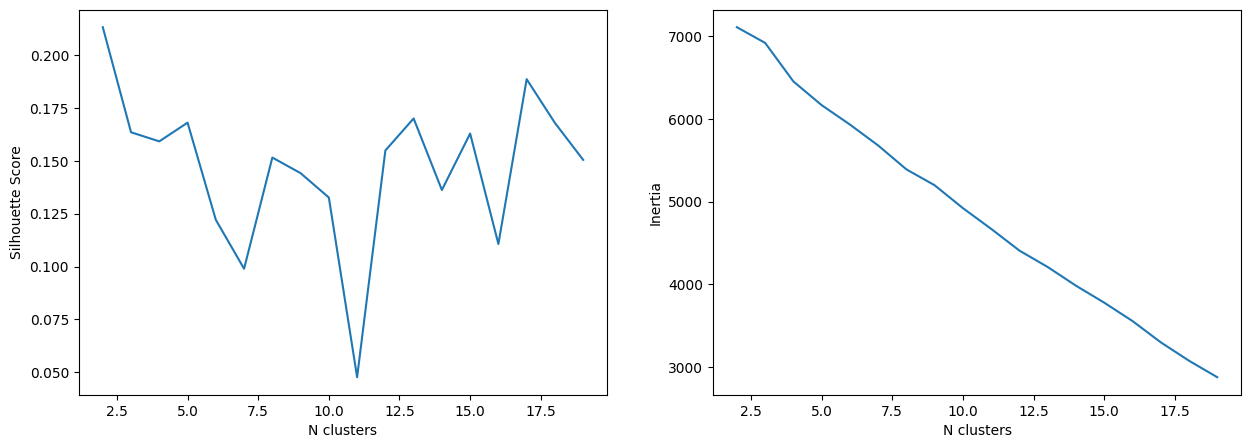

In [58]:
## Clustering
silhouette = []
n_clusters = []
inertia = []

for n in range(2,20):
    clustering_model = cluster_data(characteristics_data, n_clusters=n)
    silhouette.append(silhouette_score(characteristics_data, clustering_model.labels_))
    n_clusters.append(len(np.unique(clustering_model.labels_)))
    inertia.append(clustering_model.inertia_)   
    try:
        print(f'silhouette_score={silhouette_score(characteristics_data, clustering_model.labels_)}, n_clusters={len(np.unique(clustering_model.labels_))} inertia={clustering_model.inertia_}')
    except ValueError:
        pass

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(n_clusters, silhouette)
axs[0].set_xlabel('N clusters')
axs[0].set_ylabel('Silhouette Score')

axs[1].plot(n_clusters, inertia)
axs[1].set_xlabel('N clusters')
axs[1].set_ylabel('Inertia')


Silhouette_score:0.16807334982165165
N. clusters: 5


C:\Users\rmoldes\AppData\Local\Temp\ipykernel_20812\904295044.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.round(ax.get_xticks(), 2), fontsize=12)
C:\Users\rmoldes\AppData\Local\Temp\ipykernel_20812\904295044.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=12)


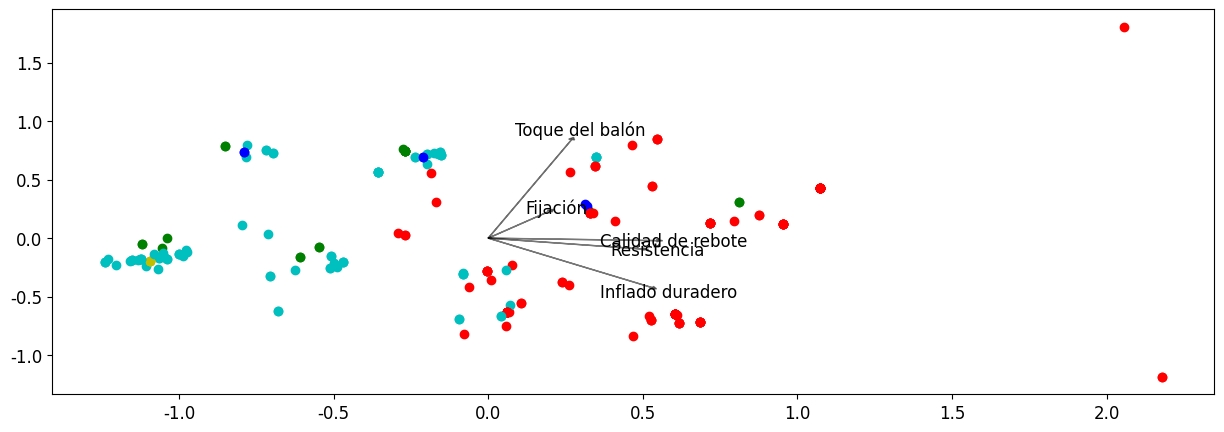

(<Figure size 1500x500 with 1 Axes>, <Axes: >)

In [59]:
## With a low value of min_samples we obtain a lot of clusters, which is not desirable. Therefore we will choose a moderate value and a low value of eps
best_model = cluster_data(characteristics_data, n_clusters= 5)
print(f"Silhouette_score:{silhouette_score(characteristics_data, best_model.labels_)}")
print(f"N. clusters: {len(np.unique(best_model.labels_))}")


plot_clustering_results(characteristics_data, best_model)

In [60]:
## Remove the caracteristics column and set a new one called profile
characteristics_data['profile'] = best_model.labels_
characteristics_data = characteristics_data.drop([col for col in characteristics_data.columns if col != 'profile'], axis=1)
data = product_data.join(characteristics_data, how='inner', on = 'product_id')
print(data.head())

            price rating brand_encoded genre_encoded discount_magnitude  \
product_id                                                                
8821974     21.99    4.5            48             2               10.0   
8869111     23.99    4.6             0             2                6.0   
8869113     31.99    3.8             0             2                8.0   
8789910      9.99    4.3            33             2                0.0   
8547126      6.99    4.7            58             2                0.0   

            profile  
product_id           
8821974           4  
8869111           0  
8869113           0  
8789910           0  
8547126           0  


## Look for correlated features

<Axes: >

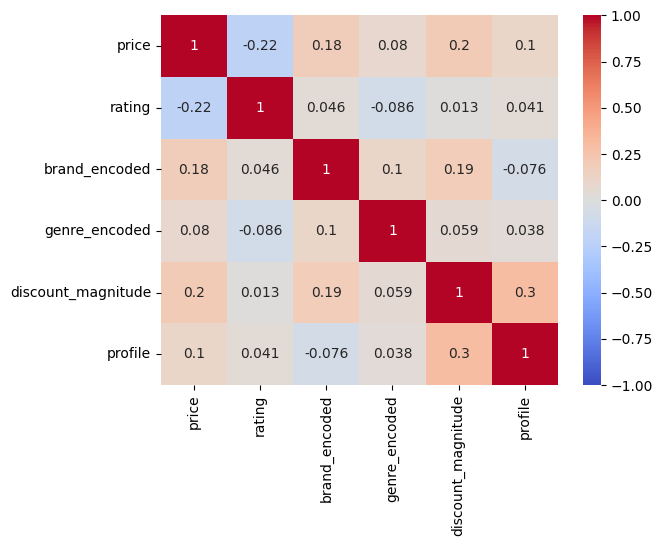

In [61]:
import seaborn as sns
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
## No strong correlations between the variables

## Step 3: Data modelling

In [69]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

TEST_SIZE = 0.25
FEATURES = [col for col in data.columns if col not in ['rating'] and col not in characteristics_data.columns]
TARGET = 'rating'

def train_model(data, target= TARGET, model=DecisionTreeRegressor, **kwargs):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model = model(**kwargs)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return model, mse, r2


search = GridSearchCV(DecisionTreeRegressor(), param_grid={'max_depth': [5, 6, 7, 8, 9, 10], 'splitter': ['best', 'random'], 'min_samples_split':[0.1,0.2,0.5,0.75,2,3], 'min_samples_leaf':[0.1,0.2,0.5,0.75,2,3],
                                                           'max_features':['sqrt', 'log2'], 'min_impurity_decrease': np.arange(0.1,5,0.5)}, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
search.fit(data[FEATURES], data[TARGET])
print(search.best_params_)

{'max_depth': 9, 'max_features': 'sqrt', 'min_impurity_decrease': 0.1, 'min_samples_leaf': 0.2, 'min_samples_split': 0.2, 'splitter': 'best'}


MSE: 3.5995114087301587, R2: -0.014650481414765437)


<Axes: >

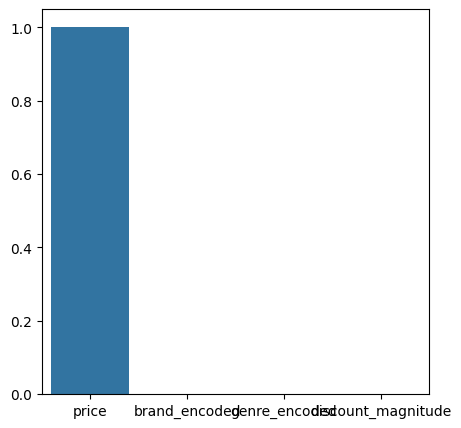

In [71]:
model, mse, r2 = train_model(data, model=DecisionTreeRegressor, max_depth=9, max_features ='sqrt', min_impurity_decrease=0.1, min_samples_leaf =0.2, min_samples_split=0.2, splitter='best')
print(f'MSE: {mse}, R2: {r2})')
fig ,ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=FEATURES, y=search.best_estimator_.feature_importances_, ax=ax)